## INTRODUCTION

**Text summarization** techniques can be broadly categorized into two main types: **Extractive summarization** and **abstractive summarization.**

**1. Extractive Summarization:**

**1.1 Selection-based:** Extractive summarization methods select the most important sentences or phrases from the original text and concatenate them to form a summary. These methods typically rely on features such as sentence importance scores, sentence length, or keyword frequency to identify salient information.

**1.2 Graph-based:** Graph-based methods represent the text as a graph, where sentences are nodes and edges represent relationships between sentences. Important sentences are then identified using graph algorithms such as PageRank or centrality measures.


**2. Abstractive Summarization:**

**2.1 Generation-based:** Abstractive summarization methods generate a summary by paraphrasing and rephrasing the original text in a more concise form. These methods often employ deep learning models such as recurrent neural networks (RNNs), transformers, or sequence-to-sequence models with attention mechanisms to understand and generate human-like summaries.

**2.2 Reinforcement Learning-based:** Some abstractive summarization techniques use reinforcement learning to train models to generate summaries that maximize a predefined reward function. These methods learn to balance between informativeness and fluency by optimizing the reward signal.

Each type of summarization technique has its advantages and disadvantages, and the choice of method depends on factors such as the nature of the input text, desired level of abstraction, and computational resources available.


In this notebook, **we will train Large Language Model(BART from hugging face) to perform abstractive text summarizatio**n. BART is already pre trained with a lot of real world text and currentky has the ability to summarize text but we will be fine tuning it so it can summarize dialogue based text.


BART, or Bidirectional and Auto-Regressive Transformers, is a sequence-to-sequence model introduced by Lewis et al. (2019). It is a denoising autoencoder for pretraining sequence-to-sequence models and can be fine-tuned for a variety of natural language processing (NLP) tasks, including text summarization, machine translation, and text generation.BART is part of the Hugging Face Transformers library. Hugging Face Transformers is an open-source library that provides easy access to a wide range of pre-trained transformer models, including BART. These models can be used for various natural language processing (NLP) tasks such as text classification, machine translation, text generation, and summarization. By leveraging the Hugging Face Transformers library, developers and researchers can easily access state-of-the-art models like BART and fine-tune them for specific NLP tasks, making it a valuable tool for the NLP community.


**Here are some key features and components of BART:**


1. Architecture: BART is built upon the transformer architecture, which includes an encoder and a decoder. It utilizes the self-attention mechanism to capture dependencies between tokens in the input sequence.

2. Bidirectional Pretraining: BART is pretrained using a denoising autoencoder objective, where it is trained to reconstruct the original input sequence from a corrupted version of the sequence. This bidirectional pretraining enables BART to generate coherent and contextually relevant outputs during inference.

3. Masked Language Modeling (MLM): Similar to other transformer-based models, BART is pretrained using the MLM objective, where a certain percentage of tokens in the input sequence are replaced with a special token and the model is trained to predict the original tokens.

4. Denoising Objective: BART introduces a novel factorization of the autoregressive likelihood called the "uni-directional" objective, which enables it to handle both left-to-right and right-to-left decoders during pretraining.

5. Fine-tuning: After pretraining, BART can be fine-tuned on downstream tasks using supervised learning. For tasks like text summarization, the decoder is typically fine-tuned with an autoregressive objective, where the model predicts each token in the summary conditioned on the input sequence.

6. Applications: BART has demonstrated strong performance on various NLP tasks, including text summarization, machine translation, document classification, and text generation. Its ability to generate fluent and coherent text makes it particularly well-suited for tasks requiring natural language understanding and generation.

Overall, BART represents a powerful and versatile architecture for sequence-to-sequence modeling in NLP, with applications across a wide range of tasks and domains.

Lets start Importing required libraries below:

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.8 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [2]:
# Data Handling
import pandas as pd
import numpy as np
from datasets import Dataset, load_metric

# Hiding warnings
import warnings
warnings.filterwarnings("ignore")

# Transformers
from transformers import BartTokenizer, BartForConditionalGeneration      # BERT Tokenizer and architecture
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments         # These will help us to fine-tune our model
from transformers import pipeline                                         # Pipeline
from transformers import DataCollatorForSeq2Seq                           # DataCollator to batch the data
import torch                                                              # PyTorch

import re                                                                 # This library allows us to clean text data
import nltk                                                               # Natural Language Toolkit
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

To see all the text in each column, we adjust the column width

In [3]:
pd.set_option('display.max_colwidth', 1000)

## Data Analysis

In [4]:
!pip install kaggle

In [5]:
pwd

'/content'

In [6]:
mkdir .kaggle

In [7]:
#importing json file
import json
token = {"username":"divyamdogra","key":""}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [8]:
ls -la

total 20
drwxr-xr-x 1 root root 4096 Aug 22 05:35 ./
drwxr-xr-x 1 root root 4096 Aug 22 05:33 ../
drwxr-xr-x 4 root root 4096 Aug 20 13:22 .config/
drwxr-xr-x 2 root root 4096 Aug 22 05:35 .kaggle/
drwxr-xr-x 1 root root 4096 Aug 20 13:23 sample_data/


In [9]:
cd /root

/root


In [10]:
ls -la

total 80
drwx------ 1 root root 4096 Aug 22 05:35 ./
drwxr-xr-x 1 root root 4096 Aug 22 05:33 ../
-r-xr-xr-x 1 root root 1169 Jan  1  2000 .bashrc*
drwxr-xr-x 1 root root 4096 Aug 22 05:35 .cache/
drwxr-xr-x 3 root root 4096 Aug 20 13:45 .config/
drwxr-xr-x 1 root root 4096 Aug 20 13:44 .ipython/
drwx------ 1 root root 4096 Aug 20 13:44 .jupyter/
drwxr-xr-x 2 root root 4096 Aug 22 05:33 .keras/
drwx------ 3 root root 4096 Aug 20 13:14 .launchpadlib/
drwxr-xr-x 1 root root 4096 Aug 20 13:44 .local/
drwxr-xr-x 3 root root 4096 Aug 22 05:35 nltk_data/
drwxr-xr-x 4 root root 4096 Aug 20 13:45 .npm/
-rw-r--r-- 1 root root  161 Jul  9  2019 .profile
-r-xr-xr-x 1 root root  254 Jan  1  2000 .tmux.conf*
-rw-r--r-- 1 root root  211 Aug 20 13:44 .wget-hsts


In [11]:
!mkdir .kaggle

In [12]:
cd /root/.kaggle

/root/.kaggle


In [13]:
!cp /content/.kaggle/kaggle.json /root/.kaggle/kaggle.json

In [14]:
ls -la

total 16
drwxr-xr-x 2 root root 4096 Aug 22 05:35 ./
drwx------ 1 root root 4096 Aug 22 05:35 ../
-rw-r--r-- 1 root root   70 Aug 22 05:35 kaggle.json


In [15]:
cd /content

/content


In [16]:
!chmod 600 ~/.kaggle/kaggle.json

In [17]:
!kaggle datasets download -d marawanxmamdouh/dialogsum -p /content/dialogs

Dataset URL: https://www.kaggle.com/datasets/marawanxmamdouh/dialogsum
License(s): other
 87% 7.00M/8.05M [00:00<00:00, 13.6MB/s]
100% 8.05M/8.05M [00:00<00:00, 10.8MB/s]


In [18]:
cd dialogs

/content/dialogs


In [19]:
!unzip '/content/dialogs/dialogsum.zip'

Archive:  /content/dialogs/dialogsum.zip
  inflating: CSV/hiddentest_dialogue.csv  
  inflating: CSV/hiddentest_topic.csv  
  inflating: CSV/test.csv            
  inflating: CSV/train.csv           
  inflating: CSV/validation.csv      
  inflating: JSONL/hiddentest_dialogue.jsonl  
  inflating: JSONL/hiddentest_topic.jsonl  
  inflating: JSONL/test.jsonl        
  inflating: JSONL/train.jsonl       
  inflating: JSONL/validation.jsonl  


In [20]:
# Loading data
train = pd.read_csv('/content/dialogs/CSV/train.csv')
test = pd.read_csv('/content/dialogs/CSV/test.csv')
val = pd.read_csv('/content/dialogs/CSV/validation.csv')

Joining all three dataframes together for easy analysis

In [21]:
# Concatenate vertically
df = pd.concat([train, test, val], ignore_index=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14460 entries, 0 to 14459
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        14460 non-null  object
 1   dialogue  14460 non-null  object
 2   summary   14460 non-null  object
 3   topic     14460 non-null  object
dtypes: object(4)
memory usage: 452.0+ KB


Checking for null columns and duplicates

In [22]:
# Check for null columns
null_columns = df.columns[df.isnull().any()]

# Print the null columns if any
if len(null_columns) > 0:
    print("Null columns found:")
    print(null_columns)
else:
    print("No null columns found.")

No null columns found.


In [23]:
# Check for duplicate rows
duplicate_rows = df[df.duplicated()]

# Print the duplicate rows if any
if not duplicate_rows.empty:
    print("Duplicate rows found:")
    print(duplicate_rows)
else:
    print("No duplicate rows found.")

No duplicate rows found.


In [24]:
#Lets look at the first 20 rows of the dataset
df.head(20)

,id,dialogue,summary,topic
0,train_0,"#Person1#: Hi, Mr. Smith. I'm Doctor Hawkins. Why are you here today?\n#Person2#: I found it would be a good idea to get a check-up.\n#Person1#: Yes, well, you haven't had one for 5 years. You should have one every year.\n#Person2#: I know. I figure as long as there is nothing wrong, why go see the doctor?\n#Person1#: Well, the best way to avoid serious illnesses is to find out about them early. So try to come at least once a year for your own good.\n#Person2#: Ok.\n#Person1#: Let me see here. Your eyes and ears look fine. Take a deep breath, please. Do you smoke, Mr. Smith?\n#Person2#: Yes.\n#Person1#: Smoking is the leading cause of lung cancer and heart disease, you know. You really should quit.\n#Person2#: I've tried hundreds of times, but I just can't seem to kick the habit.\n#Person1#: Well, we have classes and some medications that might help. I'll give you more information before you leave.\n#Person2#: Ok, thanks doctor.","Mr. Smith's getting a check-up, and Doctor Hawkins advises him to have one every year. Hawkins'll give some information about their classes and medications to help Mr. Smith quit smoking.",get a check-up
1,train_1,"#Person1#: Hello Mrs. Parker, how have you been?\n#Person2#: Hello Dr. Peters. Just fine thank you. Ricky and I are here for his vaccines.\n#Person1#: Very well. Let's see, according to his vaccination record, Ricky has received his Polio, Tetanus and Hepatitis B shots. He is 14 months old, so he is due for Hepatitis A, Chickenpox and Measles shots.\n#Person2#: What about Rubella and Mumps?\n#Person1#: Well, I can only give him these for now, and after a couple of weeks I can administer the rest.\n#Person2#: OK, great. Doctor, I think I also may need a Tetanus booster. Last time I got it was maybe fifteen years ago!\n#Person1#: We will check our records and I'll have the nurse administer and the booster as well. Now, please hold Ricky's arm tight, this may sting a little.",Mrs Parker takes Ricky for his vaccines. Dr. Peters checks the record and then gives Ricky a vaccine.,vaccines
2,train_2,"#Person1#: Excuse me, did you see a set of keys?\n#Person2#: What kind of keys?\n#Person1#: Five keys and a small foot ornament.\n#Person2#: What a shame! I didn't see them.\n#Person1#: Well, can you help me look for it? That's my first time here.\n#Person2#: Sure. It's my pleasure. I'd like to help you look for the missing keys.\n#Person1#: It's very kind of you.\n#Person2#: It's not a big deal.Hey, I found them.\n#Person1#: Oh, thank God! I don't know how to thank you, guys.\n#Person2#: You're welcome.",#Person1#'s looking for a set of keys and asks for #Person2#'s help to find them.,find keys
3,train_3,"#Person1#: Why didn't you tell me you had a girlfriend?\n#Person2#: Sorry, I thought you knew.\n#Person1#: But you should tell me you were in love with her.\n#Person2#: Didn't I?\n#Person1#: You know you didn't.\n#Person2#: Well, I am telling you now.\n#Person1#: Yes, but you might have told me before.\n#Person2#: I didn't think you would be interested.\n#Person1#: You can't be serious. How dare you not tell me you are going to marry her?\n#Person2#: Sorry, I didn't think it mattered.\n#Person1#: Oh, you men! You are all the same.",#Person1#'s angry because #Person2# didn't tell #Person1# that #Person2# had a girlfriend and would marry her.,have a girlfriend
4,train_4,"#Person1#: Watsup, ladies! Y'll looking'fine tonight. May I have this dance?\n#Person2#: He's cute! He looks like Tiger Woods! But, I can't dance. . .\n#Person1#: It's all good. I'll show you all the right moves. My name's Malik.\n#Person2#: Nice to meet you. I'm Wen, and this is Nikki.\n#Person1#: How you feeling', vista? Mind if I take your friend'round the dance floor?\n#Person2#: She doesn't mind if you don't mind getting your feet stepped on.\n#Person1#: Right. Cool! Let's go!",Malik invites Nikki to dance. Nikki agrees if Malik doesn't mind getting his feet stepped on.,dance
5,train_5,"#Pers

## Data Preprocessing¶

We will remove the hashtags, punctuation and the line seperators(\n) from the text to reduce noise during training

In [25]:
import re

# Function to clean text
def clean_text(text):
    # Remove special characters like \n and #
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'[#]', '', text)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    return text

# Apply cleaning function to 'dialogue' and 'summary' columns
df['dialogue'] = df['dialogue'].apply(clean_text)
df['summary'] = df['summary'].apply(clean_text)

df.head(10)

,id,dialogue,summary,topic
0,train_0,Person1 Hi Mr Smith Im Doctor Hawkins Why are you here today Person2 I found it would be a good idea to get a checkup Person1 Yes well you havent had one for 5 years You should have one every year Person2 I know I figure as long as there is nothing wrong why go see the doctor Person1 Well the best way to avoid serious illnesses is to find out about them early So try to come at least once a year for your own good Person2 Ok Person1 Let me see here Your eyes and ears look fine Take a deep breath please Do you smoke Mr Smith Person2 Yes Person1 Smoking is the leading cause of lung cancer and heart disease you know You really should quit Person2 Ive tried hundreds of times but I just cant seem to kick the habit Person1 Well we have classes and some medications that might help Ill give you more information before you leave Person2 Ok thanks doctor,Mr Smiths getting a checkup and Doctor Hawkins advises him to have one every year Hawkinsll give some information about their classes and medications to help Mr Smith quit smoking,get a check-up
1,train_1,Person1 Hello Mrs Parker how have you been Person2 Hello Dr Peters Just fine thank you Ricky and I are here for his vaccines Person1 Very well Lets see according to his vaccination record Ricky has received his Polio Tetanus and Hepatitis B shots He is 14 months old so he is due for Hepatitis A Chickenpox and Measles shots Person2 What about Rubella and Mumps Person1 Well I can only give him these for now and after a couple of weeks I can administer the rest Person2 OK great Doctor I think I also may need a Tetanus booster Last time I got it was maybe fifteen years ago Person1 We will check our records and Ill have the nurse administer and the booster as well Now please hold Rickys arm tight this may sting a little,Mrs Parker takes Ricky for his vaccines Dr Peters checks the record and then gives Ricky a vaccine,vaccines
2,train_2,Person1 Excuse me did you see a set of keys Person2 What kind of keys Person1 Five keys and a small foot ornament Person2 What a shame I didnt see them Person1 Well can you help me look for it Thats my first time here Person2 Sure Its my pleasure Id like to help you look for the missing keys Person1 Its very kind of you Person2 Its not a big dealHey I found them Person1 Oh thank God I dont know how to thank you guys Person2 Youre welcome,Person1s looking for a set of keys and asks for Person2s help to find them,find keys
3,train_3,Person1 Why didnt you tell me you had a girlfriend Person2 Sorry I thought you knew Person1 But you should tell me you were in love with her Person2 Didnt I Person1 You know you didnt Person2 Well I am telling you now Person1 Yes but you might have told me before Person2 I didnt think you would be interested Person1 You cant be serious How dare you not tell me you are going to marry her Person2 Sorry I didnt think it mattered Person1 Oh you men You are all the same,Person1s angry because Person2 didnt tell Person1 that Person2 had a girlfriend and would marry her,have a girlfriend
4,train_4,Person1 Watsup ladies Yll lookingfine tonight May I have this dance Person2 Hes cute He looks like Tiger Woods But I cant dance Person1 Its all good Ill show you all the right moves My names Malik Person2 Nice to meet you Im Wen and this is Nikki Person1 How you feeling vista Mind if I take your friendround the dance floor Person2 She doesnt mind if you dont mind getting your feet stepped on Person1 Right Cool Lets go,Malik invites Nikki to dance Nikki agrees if Malik doesnt mind getting his feet stepped on,dance
5,train_5,Person1 Happy birthday Aims Person2 Thank you Lisa Person1 Here is a present for you I hope you like it Person2 Oh great I love it You know Ive been expecting this for a long time Person1 Im very glad to hear that Person2 Come here let me introduce some friends to you,Lisa gives Aims a birthday present and Aims loves it,birthday
6,train_6,Person1 Here we come Person2 Thank you Whats the fare P

In [26]:
# Drop the 'id' and 'topic' columns from the DataFrame
df.drop(columns=['id', 'topic'], inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14460 entries, 0 to 14459
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   dialogue  14460 non-null  object
 1   summary   14460 non-null  object
dtypes: object(2)
memory usage: 226.1+ KB


We want to add two columns to see the text length distribution for the dialogue and summary columns. These length columns will help us determine the tokenization length before training the model.

In [27]:
# Add two columns for text length of dialogue and summary
df['Dialogue Length'] = df['dialogue'].apply(len)
df['Summary Length'] = df['summary'].apply(len)

# Display the modified DataFrame
df.head(2)

,dialogue,summary,Dialogue Length,Summary Length
0,Person1 Hi Mr Smith Im Doctor Hawkins Why are you here today Person2 I found it would be a good idea to get a checkup Person1 Yes well you havent had one for 5 years You should have one every year Person2 I know I figure as long as there is nothing wrong why go see the doctor Person1 Well the best way to avoid serious illnesses is to find out about them early So try to come at least once a year for your own good Person2 Ok Person1 Let me see here Your eyes and ears look fine Take a deep breath please Do you smoke Mr Smith Person2 Yes Person1 Smoking is the leading cause of lung cancer and heart disease you know You really should quit Person2 Ive tried hundreds of times but I just cant seem to kick the habit Person1 Well we have classes and some medications that might help Ill give you more information before you leave Person2 Ok thanks doctor,Mr Smiths getting a checkup and Doctor Hawkins advises him to have one every year Hawkinsll give some information about their classes and medications to help Mr Smith quit smoking,854,179
1,Person1 Hello Mrs Parker how have you been Person2 Hello Dr Peters Just fine thank you Ricky and I are here for his vaccines Person1 Very well Lets see according to his vaccination record Ricky has received his Polio Tetanus and Hepatitis B shots He is 14 months old so he is due for Hepatitis A Chickenpox and Measles shots Person2 What about Rubella and Mumps Person1 Well I can only give him these for now and after a couple of weeks I can administer the rest Person2 OK great Doctor I think I also may need a Tetanus booster Last time I got it was maybe fifteen years ago Person1 We will check our records and Ill have the nurse administer and the booster as well Now please hold Rickys arm tight this may sting a little,Mrs Parker takes Ricky for his vaccines Dr Peters checks the record and then gives Ricky a vaccine,724,98


In [28]:
#view top 5 in the dialogue length column
df.sort_values(by=['Dialogue Length']).head(5)

,dialogue,summary,Dialogue Length,Summary Length
6207,Person1 Jack do say goodbye for me to the host Ive got to run Person2 Why are you in such a hurry Person1 My old man does not allow me to go back later than 11 p m Bye Person2 Bye,Person1 hurries to leave because of Person1s curfew,179,51
8730,Person1 Did you hear that Anna needs to stay in bed for 4 weeks Person2 Yeah She injured her spine in a fall and a doctor told her to lie flat on her back for a month so it can mend,Anna needs to stay in bed for her spine injury,181,46
4980,Person1 My son closed his ear to what I said I dont know what I should do Person2 You can twist his arm in order to have a control of him Person1 I cannot have the heart to do that,Person1s son is disobedient Person2 suggests using violence,183,59
9882,Person1 I am so sorry that I must be off now My girlfriend told me I must arrive at her home in ten minutes or she will break up with me Person2 She can cope with it Dont be such a wimp,Person1 must be off to meet Person1s girlfriend,185,47
426,Person1 Can you tell us what you like doing in the evening Person2 Well I like music I listen to a lot of pop music But most of all I like watching TV Its much better than reading a book,Person2 tells Person1 what Person2 likes doing in the evening,186,61


Viewing the histograms and the barplots of text lengths


We see that the majority of the text for the dialogue column is between 0 and 1000 and for the summary the range is 0-200 mostly.

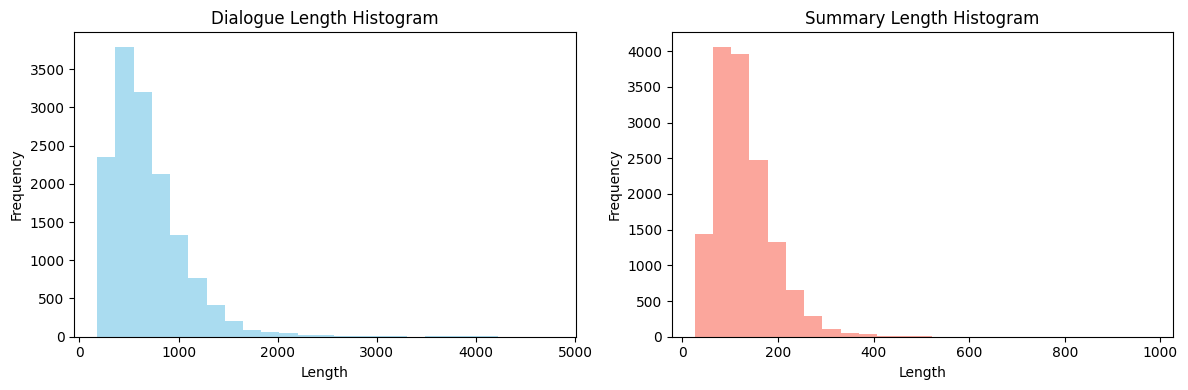

In [29]:
import matplotlib.pyplot as plt

# Create a figure and axes objects
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot histograms for Dialogue Length and Summary Length
df['Dialogue Length'].plot(kind='hist', bins=25, color='skyblue', alpha=0.7, ax=axes[0])
axes[0].set_title('Dialogue Length Histogram')
axes[0].set_xlabel('Length')
axes[0].set_ylabel('Frequency')

df['Summary Length'].plot(kind='hist', bins=25, color='salmon', alpha=0.7, ax=axes[1])
axes[1].set_title('Summary Length Histogram')
axes[1].set_xlabel('Length')
axes[1].set_ylabel('Frequency')

# Show the plot
plt.tight_layout()
plt.show()

We can see the outliers in both columns which should not be a problem

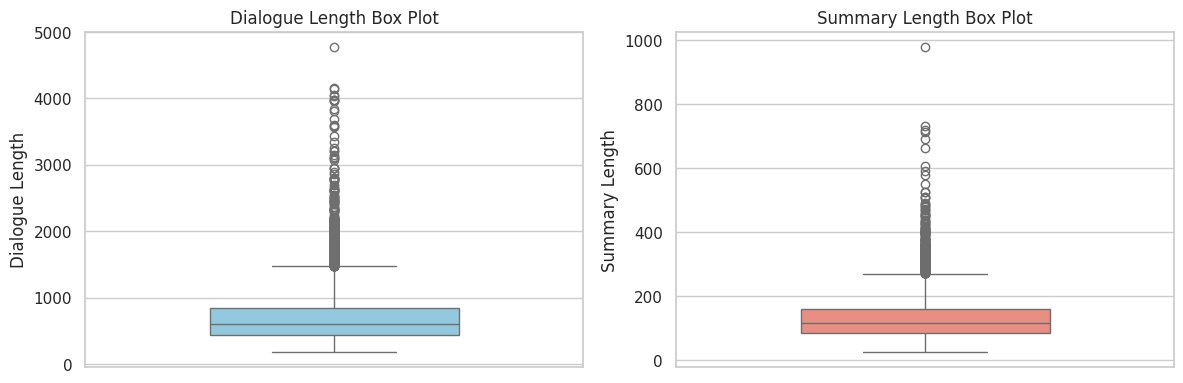

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for seaborn
sns.set(style="whitegrid")

# Create a figure and axes objects
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot box plots for Dialogue Length and Summary Length with customized appearance
sns.boxplot(y=df['Dialogue Length'], ax=axes[0], color='skyblue', width=0.5)
axes[0].set_title('Dialogue Length Box Plot')
axes[0].set_ylabel('Dialogue Length')

sns.boxplot(y=df['Summary Length'], ax=axes[1], color='salmon', width=0.5)
axes[1].set_title('Summary Length Box Plot')
axes[1].set_ylabel('Summary Length')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [31]:
# Drop the 'id' and 'topic' columns from the DataFrame
df.drop(columns=['Dialogue Length', 'Summary Length'], inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14460 entries, 0 to 14459
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   dialogue  14460 non-null  object
 1   summary   14460 non-null  object
dtypes: object(2)
memory usage: 226.1+ KB


## Data Split

In [32]:
from sklearn.model_selection import train_test_split

# Split the data into train and temp_data
train, temp = train_test_split(df, test_size=0.3, random_state=42)

# Split the temp_data into test and validation
test, val = train_test_split(temp, test_size=0.5, random_state=42)

# Print the sizes of the datasets
print("Train dataset size:", len(train))
print("Test dataset size:", len(test))
print("Validation dataset size:", len(val))

Train dataset size: 10122
Test dataset size: 2169
Validation dataset size: 2169


Converting dataframes into datasets before training helps in several ways:--

1. **Standardization:** Datasets ensure a standardized format for your data, making it easier to handle and process consistently.

2. **Compatibility:** Many machine learning libraries, including Hugging Face's transformers, are designed to work with dataset objects. By converting your dataframes into datasets, you ensure compatibility with these libraries.

3. **Efficiency:** Datasets often offer optimizations for data loading and processing, which can improve training efficiency, especially when working with large datasets.

4. **Integration with pipelines:** Datasets can be seamlessly integrated into machine learning pipelines provided by libraries like Hugging Face's transformers, simplifying the overall workflow.

5. **Functionality:** Datasets often provide useful functionalities for data manipulation, preprocessing, and splitting, which can streamline the data preparation process before training.



The 'index_level_0' column is automatically added as a **result of converting the dataframe to a dataset**. This column represents the index level of the dataframe. When you convert a dataframe to a dataset using libraries like Hugging Face's datasets, it assigns a default index level column 'index_level_0' to maintain the index information from the original dataframe. It helps to retain the integrity of the data and provides a reference to the original row indices in the dataframe. We will drop this column before training.

In [33]:
# Transforming dataframes into datasets
train_ds = Dataset.from_pandas(train)
test_ds = Dataset.from_pandas(test)
val_ds = Dataset.from_pandas(val)

# Visualizing results
print(train_ds)
print('\n' * 2)
print(test_ds)
print('\n' * 2)
print(val_ds)

Dataset({
    features: ['dialogue', 'summary', '__index_level_0__'],
    num_rows: 10122
})



Dataset({
    features: ['dialogue', 'summary', '__index_level_0__'],
    num_rows: 2169
})



Dataset({
    features: ['dialogue', 'summary', '__index_level_0__'],
    num_rows: 2169
})


In [34]:
train_ds[0] # Visualizing the first row

{'dialogue': 'Person1 Youve decided that you definitely want to purchase this particular one Person2 To be honest I havent really done much research Person1 I would recommend that you at least glance through these brochures just to make sure that you have selected the right policy for you Take your time Sir Person2 Thanks for your advice after going through all of these materials Ive decided not to go with my initial choice Person1 Of course Sir If I could have your details again and your ID Ill check them and we can go on',
 'summary': 'Person1 recommends Person2 to have a look before making a decision Person2 takes the advice and decides not to go with the initial choice',
 '__index_level_0__': 8124}

## Modelling

In [35]:
# Loading summarization pipeline with the bart-large-cnn model
summarizer = pipeline('summarization', model = 'facebook/bart-large-xsum')

config.json:   0%|          | 0.00/1.51k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/309 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In this pipeline setup, "summarization" refers to the task performed by the pipeline. The summarization pipeline, using the BART-Large-CNN model, takes in a piece of text (such as a long document or article) and generates a concise summary that captures the key points and essential information from the input text. This summarization task involves condensing the content of the input text while preserving its meaning and important details. The pipeline automates the process of summarization, making it easy to apply state-of-the-art models for generating summaries without the need for detailed model implementation.


We will now test the pre trained model to see how it performs on a regular news article without any fine tuning


Example 1

In [36]:
news = '''Problems in the homeowners insurance market pose a systemic threat to housing markets, and solving them will require extensive investments in mitigation. States and the federal government need to substantially increase investments in community risk reduction, home fortification and loss mitigation, and develop strategies to reduce insurers’ overreliance on unregulated, global reinsurance. That is the coverage that insurance companies purchase to offload some of the risk they assume for their policy holders.
Regulators should collect more information about racial homeowner insurance gaps. Historical research into racial discrimination in insurance markets has demonstrated the broad incidence of insurance “redlining,” similar to the denial of mortgages in Black and Hispanic communities. Insurance companies have not been held accountable for this. More research should be done, and regulators should use existing Fair Housing laws to investigate these gaps, and if needed, to correct them.
"When millions of American families simply cannot find or cannot afford insurance coverage for their home, we are all exposed,” said Douglas Heller, the organization's director of insurance. “Not only are uninsured families unprotected, but the economic fabric of entire communities is also at risk if significant portions of residents cannot rebuild after a disaster. Our study should be a wake-up call for lawmakers, insurance and housing regulators, and the nation’s emergency management agencies.”
'''
summarizer(news) # Using the pipeline to generate a summary of the text above

[{'summary_text': 'The National Association of Realtors (NAR) has released a report on the state of homeowners insurance in the United States.'}]

In [37]:
news = '''Israeli Prime Minister Benjamin Netanyahu on Sunday sharply rejected Senate Majority Leader Chuck Schumer’s call for new elections in his country, dismissing the push as “totally inappropriate” and harmful to Israel’s war against Hamas.
The comments are the freshest salvo in an escalating back-and-forth verbal exchange between senior Washington leaders and Israel’s prime minister, who has attracted growing criticism from the Biden administration and many Democratic lawmakers over his handling
of the conflict with Hamas amid international pleas to allow more humanitarian aid to reach Palestinians in Gaza. Netanyahu repeatedly declined to commit to holding early elections during an interview with CNN. He pointed to polling that shows a majority of Israelis want early elections, but only once the war is considered over. Going to elections now, would lead to “at least six months of national paralysis, which means we would lose the war,” Netanyahu said.
'''
summarizer(news) # Using the pipeline to generate a summary of the text above

[{'summary_text': 'US Vice President Joe Biden has called on Israel not to hold early elections, amid a growing rift between the two countries.'}]

Downloading the tokenizer and the model from huggingface library

In [38]:
checkpoint = 'facebook/bart-large-xsum' # Model
tokenizer = BartTokenizer.from_pretrained(checkpoint) # Loading Tokenizer
model = BartForConditionalGeneration.from_pretrained(checkpoint) # Loading Model

In [39]:
print(model) # Visualizing model's architecture

BartForConditionalGeneration(
  (model): BartModel(
    (shared): Embedding(50264, 1024, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): BartScaledWordEmbedding(50264, 1024, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0-11): 12 x BartEncoderLayer(
          (self_attn): BartSdpaAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_l

Explaining the different layers of the model.

Shared Embedding Layer: This layer is used for both the encoder and decoder. It consists of an embedding matrix that converts token IDs into dense vectors of fixed size (1024 in this case). This embedding layer is shared between the encoder and decoder.

Encoder: The encoder is responsible for processing the input text and extracting its representations. It consists of a stack of 12 identical encoder layers. Each encoder layer contains the following components:

1. Self-Attention Layer: This layer computes the self-attention mechanism using scaled dot-product attention.     It learns relationships between words in the input sequence to capture contextual information.

2. Feed-Forward Neural Network (FFNN): This layer applies a feed-forward neural network to each position         independently and identically. It consists of two linear transformations with a GELU activation function       in between.

3. Layer Normalization: This layer normalizes the outputs of the self-attention and FFNN layers.

4. Learned Positional Embeddings: This layer adds learned positional embeddings to the input embeddings,         enabling the model to consider the order of words in the input sequence.

Decoder: The decoder takes the encoder's output and generates the target sequence, which in the case of summarization, is the summary text. It also consists of a stack of 12 identical decoder layers, each containing:

1. Self-Attention Layer: Similar to the encoder, the decoder's self-attention layer captures relationships       between words in the target sequence.

2. Cross-Attention Layer: This layer attends to the encoder's output, helping the decoder focus on relevant       parts of the input during decoding.

3. Feed-Forward Neural Network (FFNN): Same as in the encoder, this layer applies a feed-forward neural           network to each position independently.

4. Layer Normalization: Normalizes the outputs of the self-attention, cross-attention, and FFNN layers.

LM Head (Language Modeling Head): This linear layer serves as the output layer, projecting the model's hidden states to the vocabulary size (50264 in this case) to predict the next token in the sequence.


In summary, this BART model architecture consists of shared embedding layers, encoder layers, decoder layers, and an LM head, all working together to perform conditional text generation, such as summarization.

## Fine Tuning for the dialogue summarization task

Fine-tuning a large language model refers to the process of further training a pre-trained language model on a specific downstream task or dataset. Here's how it typically works:

Pre-trained Model: Initially, a large language model (like GPT, BERT, T5, etc.) is trained on a massive corpus of text data using unsupervised learning. This pre-training process involves learning general language patterns, structures, and semantics from the text data.

Fine-tuning: After pre-training, the model can be fine-tuned on a smaller, task-specific dataset. In this process:

The pre-trained model is loaded.

Additional task-specific layers or heads may be added on top of the pre-trained model.

The model is then trained on the task-specific dataset using supervised learning.

During this training, the parameters of the pre-trained model are adjusted to better fit the target task or dataset.

The fine-tuning process typically involves updating the weights of the pre-trained model using backpropagation with task-specific labeled data.

Adapting to Specific Tasks: Fine-tuning allows the pre-trained model to adapt its knowledge to the specifics of the downstream task. For example, in natural language understanding tasks like sentiment analysis or text classification, fine-tuning helps the model learn to recognize sentiment or classify text based on the target labels.

Transfer Learning: Fine-tuning leverages the knowledge learned during pre-training and transfers it to the downstream task, enabling the model to achieve better performance with less labeled data compared to training from scratch.

Iterative Process: Fine-tuning can be an iterative process, where the model is fine-tuned on multiple datasets or tasks successively to further improve its performance or adapt to different domains.

Overall, fine-tuning a large language model allows it to be customized and optimized for specific tasks or domains, making it more effective and efficient in real-world applications.

**What is backpropagation:**

Here's a simplified explanation of how backpropagation works:

Forward Pass: During the forward pass, the input data is passed through the neural network, layer by layer, to produce an output. Each layer applies a set of learned weights and biases to the input data, and typically includes an activation function to introduce non-linearity.

Loss Calculation: Once the output is generated, a loss function is used to measure the difference between the predicted output and the true target values. The goal of training is to minimize this loss.

Backward Pass: In the backward pass, the gradients of the loss function with respect to the model parameters (weights and biases) are computed using the chain rule of calculus. This process starts from the output layer and moves backward through the network.

Gradient Descent: Once the gradients are computed, the weights and biases of the network are updated in the opposite direction of the gradients, with the aim of minimizing the loss function. This step is known as gradient descent.

Iterative Optimization: The forward pass, loss calculation, backward pass, and parameter updates are performed iteratively for a fixed number of iterations or until convergence. Each iteration improves the model's performance by adjusting the parameters to reduce the loss.

Backpropagation allows neural networks to learn from the training data by iteratively adjusting their parameters to minimize the error between predicted and actual outputs. It is a fundamental technique in deep learning and plays a crucial role in the training process of neural networks.

Below is a function to tokenize the dialogue and summary columns. Tokenization is the process of breaking down a piece of text into smaller units, typically words or subwords, called tokens. These tokens are then used as input for natural language processing (NLP) tasks such as text classification, machine translation, and sentiment analysis. Tokenization helps to standardize and simplify text data for computational analysis, enabling algorithms to understand and process human language effectively.

In [40]:
def preprocess_function(examples):
    inputs = [doc for doc in examples["dialogue"]]
    model_inputs = tokenizer(inputs, max_length=1024, truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["summary"], max_length=128, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

Tokenizing the columns:-

input_ids: This contains the tokenized representation of the input text. Each token is assigned a unique numerical identifier, and the input_ids list represents the sequence of these identifiers.

attention_mask: This is a binary mask indicating which tokens in the input_ids are actual words (1) and which are padding tokens (0). It ensures that the model only attends to the real tokens and ignores the padding tokens during training.

labels: In tasks like text generation or summarization, labels represent the target sequence that the model is trained to generate. During training, the model learns to generate this sequence given the input_ids. In some cases, this may be omitted during training, especially when the model is trained in an autoregressive manner, where the next token is predicted based on the previously generated tokens without explicit target labels.

In [41]:
# Applying preprocess_function to the datasets
tokenized_train = train_ds.map(preprocess_function, batched=True,
                               remove_columns=['dialogue', 'summary', '__index_level_0__']) # Removing features

tokenized_val = val_ds.map(preprocess_function, batched=True,
                               remove_columns=['dialogue', 'summary', '__index_level_0__']) # Removing features

tokenized_test = test_ds.map(preprocess_function, batched=True,
                               remove_columns=['dialogue', 'summary', '__index_level_0__']) # Removing features

# Printing results
print('\n' * 3)
print('Preprocessed Training Dataset:\n')
print(tokenized_train)
print('\n' * 2)
print('Preprocessed Test Dataset:\n')
print(tokenized_test)
print('\n' * 2)
print('Preprocessed Validation Dataset:\n')
print(tokenized_val)

Map:   0%|          | 0/10122 [00:00<?, ? examples/s]

Map:   0%|          | 0/2169 [00:00<?, ? examples/s]

Map:   0%|          | 0/2169 [00:00<?, ? examples/s]





Preprocessed Training Dataset:

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 10122
})



Preprocessed Test Dataset:

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 2169
})



Preprocessed Validation Dataset:

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 2169
})


In [42]:
# Selecting a sample from the dataset
sample = tokenized_train[0]

# Printing its features
print("input_ids:")
print(sample['input_ids'])
print("\n")
print("attention_mask:")
print(sample['attention_mask'])
print("\n")
print("sample:")
print(sample['labels'])
print("\n")

input_ids:
[0, 41761, 134, 370, 548, 1276, 14, 47, 2299, 236, 7, 2229, 42, 1989, 65, 18404, 176, 598, 28, 5322, 38, 2489, 9399, 269, 626, 203, 557, 18404, 134, 38, 74, 5940, 14, 47, 23, 513, 18969, 149, 209, 34050, 4123, 95, 7, 146, 686, 14, 47, 33, 3919, 5, 235, 714, 13, 47, 4624, 110, 86, 5348, 18404, 176, 4557, 13, 110, 2949, 71, 164, 149, 70, 9, 209, 3183, 38, 548, 1276, 45, 7, 213, 19, 127, 2557, 2031, 18404, 134, 1525, 768, 5348, 318, 38, 115, 33, 110, 1254, 456, 8, 110, 4576, 12285, 1649, 106, 8, 52, 64, 213, 15, 2]


attention_mask:
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


sample:
[0, 41761, 134, 10827, 18404, 176, 7, 33, 10, 356, 137, 442, 10, 568, 18404, 176, 1239, 5, 2949, 8, 11703, 45, 7, 213, 19, 5, 2

1. Input IDs: This is a sequence of token IDs representing the input text. Each token ID corresponds to a specific token in the vocabulary. In this case, the input sequence starts with a special token [CLS] (with ID 0) and is followed by a sequence of token IDs representing the dialogue. The [SEP] token (with ID 2) marks the end of the input sequence. In between, there are various token IDs representing different words or subwords in the input text.

2. Attention Mask: This is a binary mask indicating which tokens in the input sequence should be attended to (i.e., given attention) by the model and which tokens should be ignored. The value 1 indicates that the token should be attended to, while the value 0 indicates that the token should be ignored. In this case, all tokens in the input sequence have a value of 1, indicating that all tokens should be attended to.


3. Sample: This is a sequence of token IDs representing a sample output generated by the model. Similar to the input IDs, each token ID corresponds to a specific token in the vocabulary. This sequence represents a summary generated by the model based on the input dialogue. The [SEP] token marks the end of the summary sequence.


4. Padding: In NLP, sequences of words or tokens often vary in length. However, most deep learning models require fixed-length input sequences. Padding is the process of adding special tokens (usually with the ID 0) to the input sequences to make them all the same length. These padding tokens are ignored by the model during training and inference. Padding ensures that all input sequences in a batch have the same length, which is necessary for efficient batch processing.

5. Attention Mask: Attention mechanisms are a key component of transformer-based models. Attention mask is a binary mask that indicates which elements in the input sequence should be attended to and which should be ignored. In the context of transformers, attention masks are used to prevent the model from attending to padding tokens. Specifically, the attention mask has a value of 1 for tokens that should be attended to and 0 for tokens that should be ignored. By applying attention masks, the model learns to focus only on relevant tokens in the input sequence while ignoring padding tokens.

Next is DataCollatorForSeq2Seq:

This class is provided by the transformers library and is specifically designed for sequence-to-sequence tasks. It takes care of batching sequences of input-output pairs (such as source-target pairs in machine translation or dialogue summarization) and applies necessary padding and truncation to ensure that all sequences within a batch have the same length.


tokenizer:

This parameter is the tokenizer object that is used to tokenize input sequences into token IDs. It should be the same tokenizer that was used during training and that is compatible with the model being used.

In [43]:
# Instantiating Data Collator
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

### Loading evaluation metrics

**ROUGE (Recall-Oriented Understudy for Gisting Evaluation)** is a set of metrics used to evaluate the quality of summaries generated by automatic summarization systems. There are several types of ROUGE scores, each focusing on different aspects of summary evaluation:

**ROUGE-N:** ROUGE-N measures the overlap of n-grams (contiguous sequences of n tokens) between the generated summary and the reference summary. The value of N determines the size of the n-grams considered. Common choices for N include 1 (unigrams), 2 (bigrams), and sometimes higher values like 3 or 4. For example, ROUGE-1 measures the overlap of unigrams, while ROUGE-2 measures the overlap of bigrams.

**ROUGE-L:** ROUGE-L measures the longest common subsequence (LCS) between the generated summary and the reference summary. In other words, it considers the longest sequence of tokens that appear in both the generated summary and the reference summary, regardless of their order. ROUGE-L is designed to capture the structural similarity between the summaries.

**ROUGE-W:** ROUGE-W is similar to ROUGE-L but allows for some gaps between matching tokens. It penalizes gaps in the LCS, encouraging the summary to maintain coherence and fluency. ROUGE-W is particularly useful for evaluating summaries where word order may vary.

**ROUGE-S:** ROUGE-S measures skip-bigram co-occurrence between the generated summary and the reference summary. Skip-bigrams are pairs of words that appear in a certain window of tokens, regardless of their exact positions. ROUGE-S captures the semantic similarity between the summaries.

**ROUGE-SU:** ROUGE-SU extends ROUGE-S by considering skip-bigrams of varying lengths (unigrams, bigrams, trigrams, etc.). It provides a more comprehensive measure of semantic similarity by considering skip-bigrams of different sizes.

Overall, **ROUGE scores provide valuable insights into the effectiveness of automatic summarization systems** by evaluating their ability to generate summaries that are both informative and similar to human-generated summaries. Different ROUGE metrics focus on different aspects of summary quality, allowing for a comprehensive evaluation of summarization performance.

In [44]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=d48cd3eb56e7daee200d123bca7ab03fd35001c47aa9d2be4dcde0f2bc355fc3
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [45]:
metric = load_metric('rouge') # Loading ROUGE Score

The repository for rouge contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/rouge.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Below is a function to compute the metrics

In [46]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred# Obtaining predictions and true labels

    # Decoding predictions
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)

    # Obtaining the true labels tokens, while eliminating any possible masked token (i.e., label = -100)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Rouge expects a newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]


    # Computing rouge score
    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()} # Extracting some results

    # Add mean-generated length
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}

### Defining Trianing arguments

Here is an explanation of some of the key hyperparameters of our training code:

Learning Rate:

Learning rate is a hyperparameter that determines the size of the steps taken during optimization. It controls the rate at which the model parameters are updated during training. A higher learning rate may result in faster convergence but can also lead to instability or overshooting of the optimal solution. Conversely, a lower learning rate may result in slower convergence but may be more stable.

Weight Decay:

Weight decay is a regularization technique used during optimization to prevent overfitting. It adds a penalty term to the loss function that discourages large weights in the model. The weight decay parameter controls the strength of this penalty.

Gradient Accumulation:

Gradient accumulation is a technique used to simulate larger batch sizes without increasing memory usage. Instead of updating the model parameters after processing each batch, gradients are accumulated over multiple batches.The accumulated gradients are then used to perform a single update to the model parameters. This can be useful when training with large batch sizes is not feasible due to memory constraints.

Predict_with_generate:

predict_with_generate is a parameter that specifies whether the model should use generation-based prediction during evaluation.When set to True, the model generates output sequences directly during evaluation using techniques like beam search or sampling. This is commonly used in sequence-to-sequence tasks like summarization or translation.

FP16 (Mixed Precision Training):

FP16, or mixed precision training, is a technique that uses lower precision (16-bit floating-point format) arithmetic for certain parts of the training process. It can accelerate training by reducing memory usage and increasing computational throughput on GPUs that support it.However, it requires careful handling of numerical stability issues, particularly during gradient computation and parameter updates.Mixed precision training is often used in conjunction with optimization algorithms that support it, such as NVIDIA's Apex or PyTorch's native support.

In [47]:
training_args = Seq2SeqTrainingArguments(
    output_dir = 'dialoguesum',
    evaluation_strategy = "epoch",
    save_strategy = 'epoch',
    load_best_model_at_end = True,
    metric_for_best_model = 'eval_loss',
    #seed = seed,
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,
    weight_decay=0.01,
    save_total_limit=2,
    num_train_epochs=4,
    predict_with_generate=True,
    fp16=True,
    report_to="none"
)

We now define the trainer including the hyperparameters from above(training_args), model, tokenizer and the datasets we will use to train and validate the training resuts

In [48]:
# Defining Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)


In [49]:
 #Checking if GPU is available
if torch.cuda.is_available():
    print("GPU is available. \nUsing GPU")
    device = torch.device('cuda')
else:
    print("GPU is not available. \nUsing CPU")
    device = torch.device('cpu')

GPU is available. 
Using GPU


## Training

In [50]:
trainer.train() # Training model

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
0,1.469700,1.453223,50.423600,25.396100,42.106700,42.122800,32.225000
2,0.888000,1.471124,51.409000,26.071900,42.996700,43.023800,34.541300
3,0.717400,1.554267,51.668300,25.939200,42.964900,42.993700,34.547700


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 62, 'min_length': 11, 'early_stopping': True, 'num_beams': 6, 'no_repeat_ngram_size': 3, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 62, 'min_length': 11, 'early_stopping': True, 'num_beams': 6, 'no_repeat_ngram_size': 3, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a G

TrainOutput(global_step=5060, training_loss=1.0670762043225435, metrics={'train_runtime': 5861.1444, 'train_samples_per_second': 6.908, 'train_steps_per_second': 0.863, 'total_flos': 1.9604250426753024e+16, 'train_loss': 1.0670762043225435, 'epoch': 3.998419596997234})

## Evaluating the results

We will now see the actual vs predicted summary for the **first 25 rows of the test dataset.**

Number of Beams:

The parameter "num_beams" determines how many beams the beam search algorithm should maintain during decoding. A higher value of "num_beams" allows the algorithm to explore a larger portion of the search space, potentially leading to more diverse and higher-quality generated sequences. However, increasing the number of beams also increases computational complexity and may result in slower decoding.

In [51]:
from tqdm import tqdm
from rouge_score import rouge_scorer

# Initialize an empty list to store the evaluation results
evaluation_results = []

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trainer.model.to(device)

# Initialize a ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Evaluate model performance on the tokenized validation dataset
for i, example in enumerate(tqdm(test_ds, desc="Evaluating", unit=" examples")):
    # Tokenize the input text
    inputs = tokenizer(example['dialogue'], return_tensors="pt", truncation=True, max_length=512, padding="max_length").to(device)

    # Generate summary
    summary_ids = trainer.model.generate(inputs.input_ids, max_length=50, num_beams=30)
    predicted_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    # Calculate ROUGE scores
    scores = scorer.score(predicted_summary, example['summary'])

    # Append the evaluation results to the list
    evaluation_results.append({'Actual Text': example['dialogue'],
                               'Summarized Text': example['summary'],
                               'Predicted Text': predicted_summary,
                               'ROUGE-1 F1': scores['rouge1'].fmeasure,
                               'ROUGE-2 F1': scores['rouge2'].fmeasure,
                               'ROUGE-L F1': scores['rougeL'].fmeasure})

    # Display only the first 25 results
    if i == 24:
        break

# Create a DataFrame from the evaluation results
df = pd.DataFrame(evaluation_results)

df

Evaluating:   1%|          | 14/2169 [00:16<41:27,  1.15s/ examples]


,Actual Text,Summarized Text,Predicted Text,ROUGE-1 F1,ROUGE-2 F1,ROUGE-L F1
0,Person1 Excuse me Is anyone sitting here Person2 No nobody Person1 You dont mind if I smoke do you Person2 Well to be frank yes I do Person1 Oh Im sorry But this isnt a nosmoker is it I mean would you mind if I smoke here Person2 Actually it is Perhaps you havent noticed the sign Person1 Sign Whats sign Person2 There on the window Person1 Oh sorry I didnt notice it Sorry Person2 Thats all right,Person1 wants to smoke but Person2 reminds Person1 that smoking is not allowed here,Person1 asks Person2 whether Person2 minds Person1 smoking here,0.434783,0.000000,0.434783
1,Person1 Im so frustrated Person2 whats wrong Jim Person1 I called the electronics shop to find out what time they close and it took me twenty minutes to get what I wanted Person2 Twenty minutes just to find out what their business hours are Person1 yes They have some sort of digital receptionist So when I called in a machine told me to push a button for the department I wanted to be transferred to Person2 Oh I hate getting voicemail instead of a person What did you do Person1 I just kept pushing buttons I was transferred to customer service but there a machine told me to choose between technical help warranty information or price information Person2 Couldnd you choose to be transferred to a real person Person1 Eventually I did get to a real person I found out the closing time but by then the store had already closed,Jim tells Person2 hes so frustrated because it took twenty minutes to get the closing time when he called the electronics shop,Jim tells Person2 he called the electronics shop to find out what time they close but it took him twenty minutes to get what he wanted Person2 asks him to choose between technical help warranty information or price information,0.524590,0.338983,0.327869
2,Person1 How can you keep in touch with your aunt in America Person2 Oh I make a phone call once a month Person1 Its very expensive right Person2 Yeah Person1 Why not send Email through the Internet Person2 Is it convenient and cheap Person1 Sure You can send Email to each other every day through the internet In addition you can make a phone call through the internet too Person2 Really Im so glad to hear that But I dont konw how to get access to the Internet Could you show me Person1 No problem Ill tell you Person2 Ill appreciate it very much,Person1 tells Person2 Person2 can keep in touch with Person2s aunt in America through the internet and willing to show Person2 how,Person1 tells Person2 how to keep in touch with Person2s aunt in America,0.742857,0.606061,0.628571
3,Person1 I usually get a lot of information on the computer and use Email to send messages to my friends Person2 Me too Recently Im fascinated with netchat Ive made many friends on the net Every day I talk to them and share many interesting things with them I really enjoy it Person1 Dont you think its a sheer waste of both time and money Person2 Im afraid not Every coin has two sides I think using internet has a great deal to do with human interaction,Person1 and Person2 are talking about netchat Person2 thinks it has both advantages and disadvantages,Person1 thinks netchat is a waste of time and money while Person2 thinks using the internet has a great deal to do with human interaction,0.300000,0.052632,0.250000
4,Person1 Ive brought a little dog for Alice girls usually like looking after pets Person2 Thank you but Alice is only a visitor here I dont know if shell keep it Person1 To tell you the truth the dog isnt my real reason for coming I want to ask Alice if shed like to be my girlfriend Person2 Really,Person1s brought a dog for Alice and will ask her to be his girlfriend Person2s surprised,Person1 brought a dog for Alice because Person1 wants to ask Alice if she wants to be his girlfriend,0.628571,0.484848,0.628571
5,Person1 Hi Megan How are you Have you seen the doctor Person2 No its not about me Its about Bonzo Person1 What h

## Conclusion


We can see the model does a good job summarizing and in some cases provides a little more detail than the actual summary.

Inpiration from MEDIUM ARTICLE: https://ai.plainenglish.io/text-summarization-with-large-language-models-c9ae4be96863

kaggle dataset:https://www.kaggle.com/code/alkanerturan/abstractive-dialogue-summary#INTRODUCTION

